# K modes

## Using K modes algorithm to find clusters 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from scipy.stats import iqr
import time
%matplotlib inline

In [3]:
#import data

#Read in dataset with all rows included
df = pd.read_sas("Data/alldata3.sas7bdat")

scaler = StandardScaler()

df["age_sd"] = scaler.fit_transform(df[["AGE_YEARS"]])

#9965 DCD apps
dcd_apps = df[(df["eli_DCD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#9405 DCD apps to match cohort in paper
dcd_apps = dcd_apps[(dcd_apps["GENDER"]!=9)&(dcd_apps["cod_neuro"].notna())&(dcd_apps["eth_grp"]!=5)&(dcd_apps["donation_mentioned"]!=-1)&
                    (~dcd_apps["DTC_WD_TRTMENT_PRESENT"].isin([8,9]))]

/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [11]:
# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "age_sd","cod_neuro","FAMILY_CONSENT"]

dcd_cats = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "cod_neuro","FAMILY_CONSENT"]

for cat in dcd_cats:
    dcd_apps[cat] = dcd_apps[cat].astype(int)

dcd_model_data = dcd_apps.loc[:,dcd_cols]
    
dcd_train = dcd_model_data.to_numpy()

In [13]:
max_clusters = 7
n_clusters = range(2,max_clusters+1)
costs = []

for k in range(2,max_clusters+1):
    KP = KPrototypes(n_clusters=k)
    KP.fit_predict(dcd_train,categorical=list(range(0,8))+[9,10])
    costs.append(KP.cost_)

Text(0, 0.5, 'Cost')

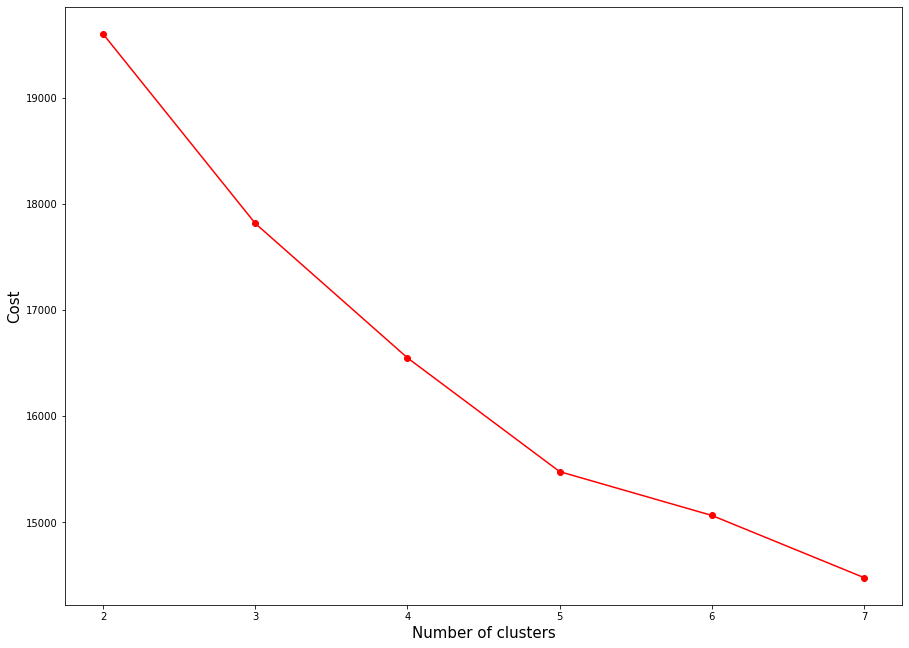

In [14]:
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.plot(n_clusters,costs,"ro-")
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Cost", fontsize=15)

In [18]:
KP = KPrototypes(n_clusters=5,random_state=66)
KP.fit_predict(dcd_train,categorical=list(range(0,8))+[9,10])
dcd_model_data["cluster_k5"] = KP.labels_

In [19]:
dcd_model_data["age"]= scaler.inverse_transform(dcd_model_data["age_sd"])

dcd_model_data.head()

,wish,donation_mentioned,app_nature,eth_grp,religion_grp,GENDER,DTC_WD_TRTMENT_PRESENT,acorn_new,age_sd,cod_neuro,FAMILY_CONSENT,cluster_k5,age
5,1,1,2,1,9,2,2,4,-1.220719,1,1,1,37.0
9,1,1,3,1,9,2,1,4,0.308154,0,1,3,65.0
13,4,1,2,1,4,2,2,6,-0.456283,1,2,4,51.0
15,1,1,2,1,9,2,2,4,1.017988,1,1,2,78.0
17,3,1,3,1,9,2,1,4,-1.220719,1,1,3,37.0


In [26]:
dcd_model_data["cluster_k5"].value_counts()

0    2707
4    2288
2    1822
3    1589
1     999
Name: cluster_k5, dtype: int64

In [25]:
k5_age_summary = dcd_model_data.iloc[:,[-2,-1]].groupby("cluster_k5").agg(["median",iqr]).T
k5_age_summary

cluster_k5     0     1     2     3     4
age median  66.0  21.0  69.0  60.0  48.0
    iqr     10.0  18.5   9.0  13.0  10.0

In [23]:
def cat_summary(k,col):
    
    summary = dcd_model_data.value_counts(["cluster_k"+str(k),col],sort=False).reset_index(name="count")
    summary["Pct"] = round(100*summary.iloc[:,-1] / summary.groupby("cluster_k"+str(k))["count"].transform('sum'),1)
    
    baseline = dcd_model_data.value_counts(col,sort=False).reset_index(name="count")
    baseline["Baseline Pct"] = round(100*baseline["count"] / baseline["count"].sum(),1)
    
    summary2 = pd.merge(summary,baseline[[col,"Baseline Pct"]],on=col,how="left")
    
    plot1 = sns.catplot(x=col,y="Pct",col="cluster_k"+str(k),data=summary2,kind='bar',color="#005EB8")
    
    print(summary2)
    
    return plot1

    cluster_k5  wish  count   Pct  Baseline Pct
0            0     1   1430  52.8          56.5
1            0     2    115   4.2           3.7
2            0     3    448  16.5          15.1
3            0     4    518  19.1          16.3
4            0     5    196   7.2           8.4
5            1     1    620  62.1          56.5
6            1     2     30   3.0           3.7
7            1     3    107  10.7          15.1
8            1     4    103  10.3          16.3
9            1     5    139  13.9           8.4
10           2     1    997  54.7          56.5
11           2     2     83   4.6           3.7
12           2     3    263  14.4          15.1
13           2     4    356  19.5          16.3
14           2     5    123   6.8           8.4
15           3     1   1102  69.4          56.5
16           3     2     26   1.6           3.7
17           3     3    175  11.0          15.1
18           3     4     82   5.2          16.3
19           3     5    204  12.8       

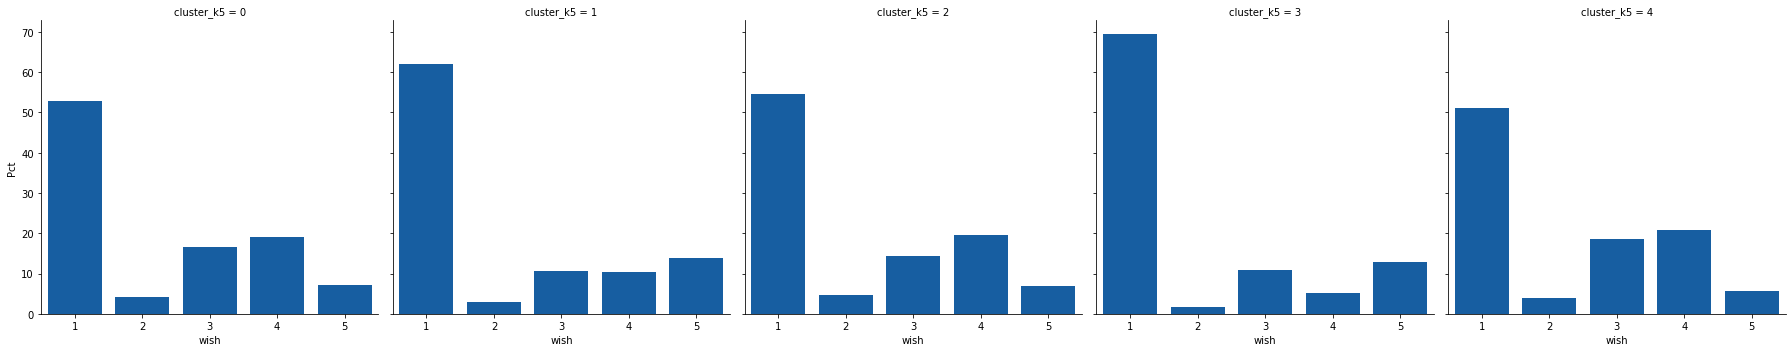

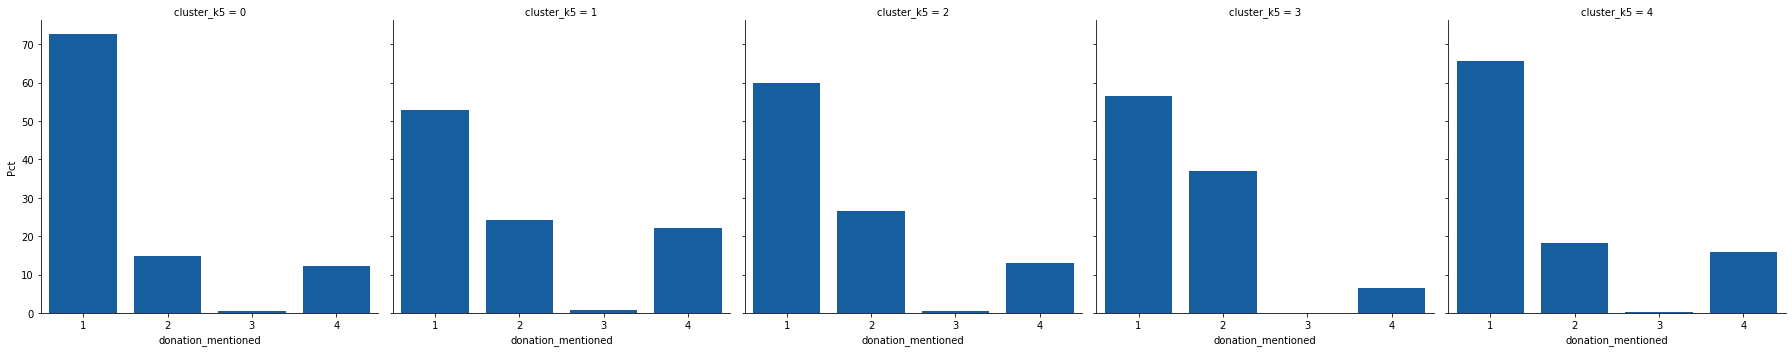

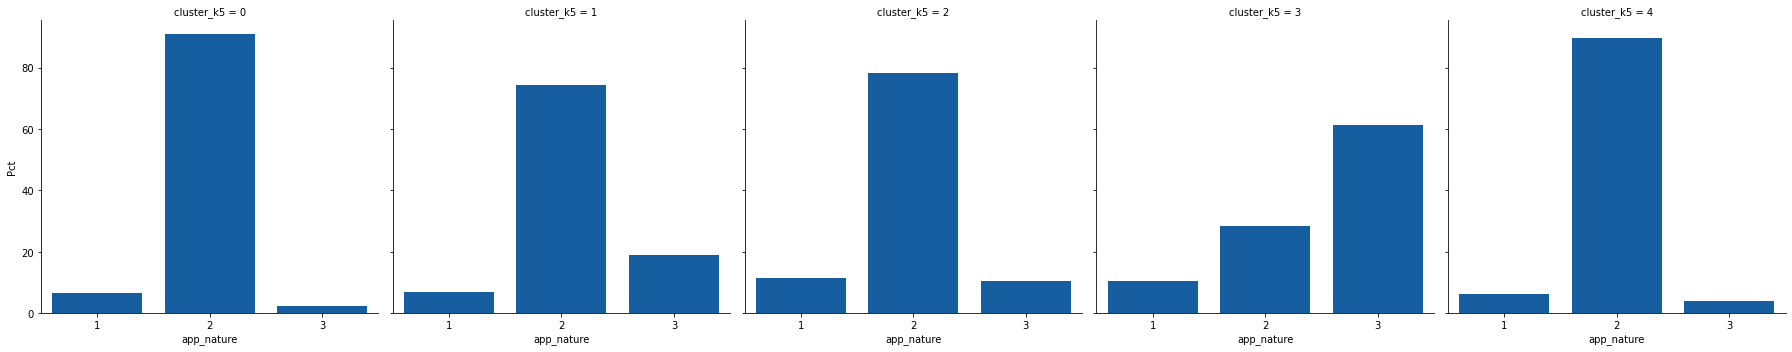

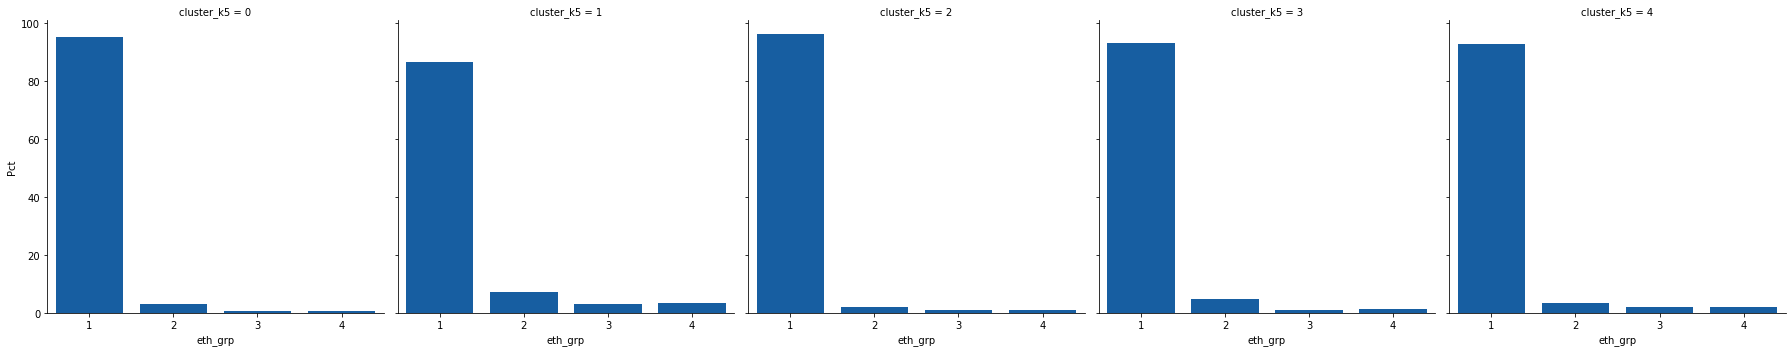

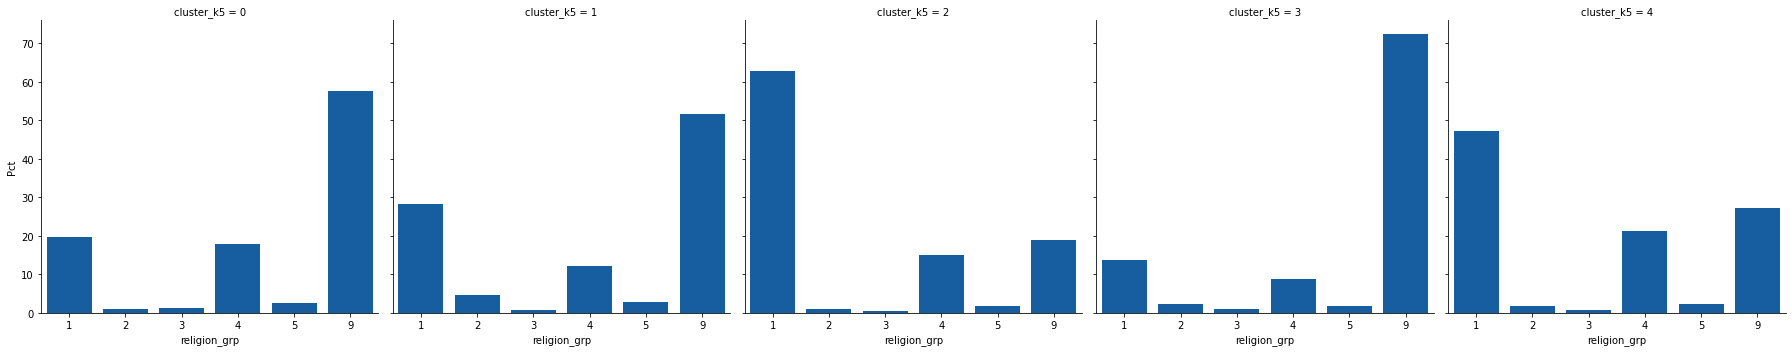

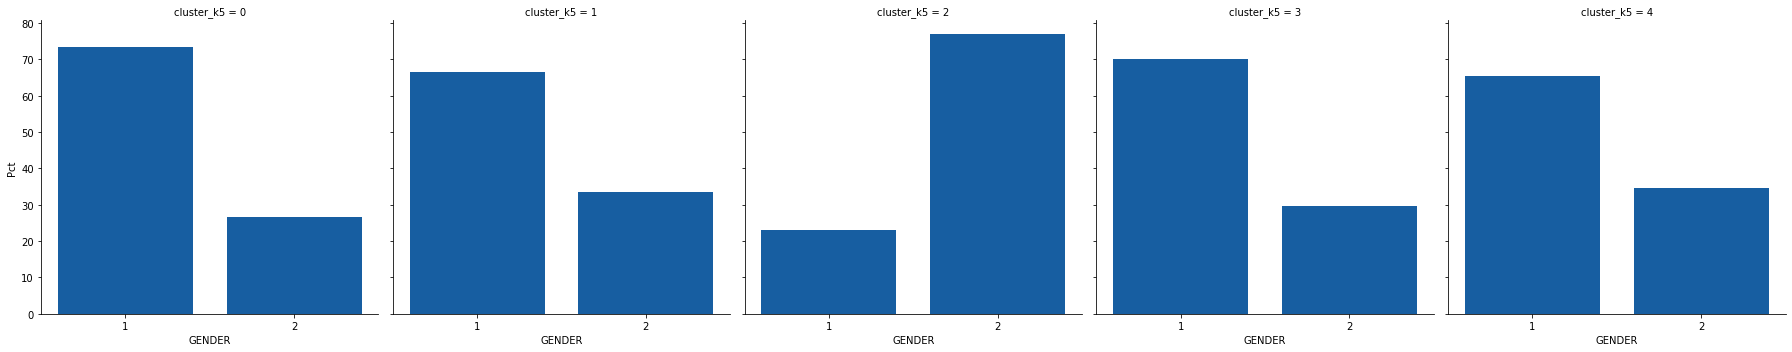

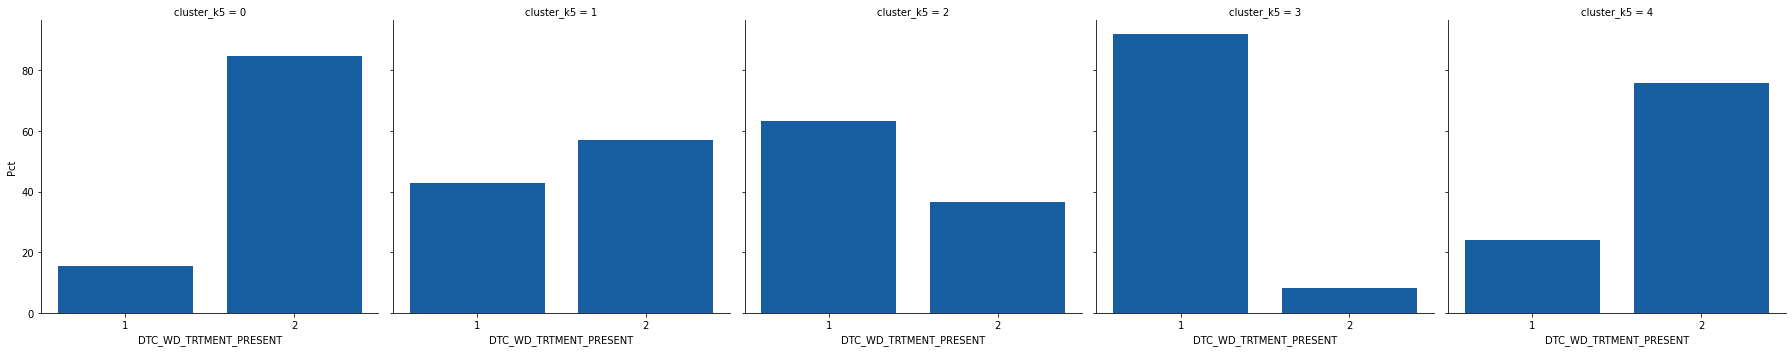

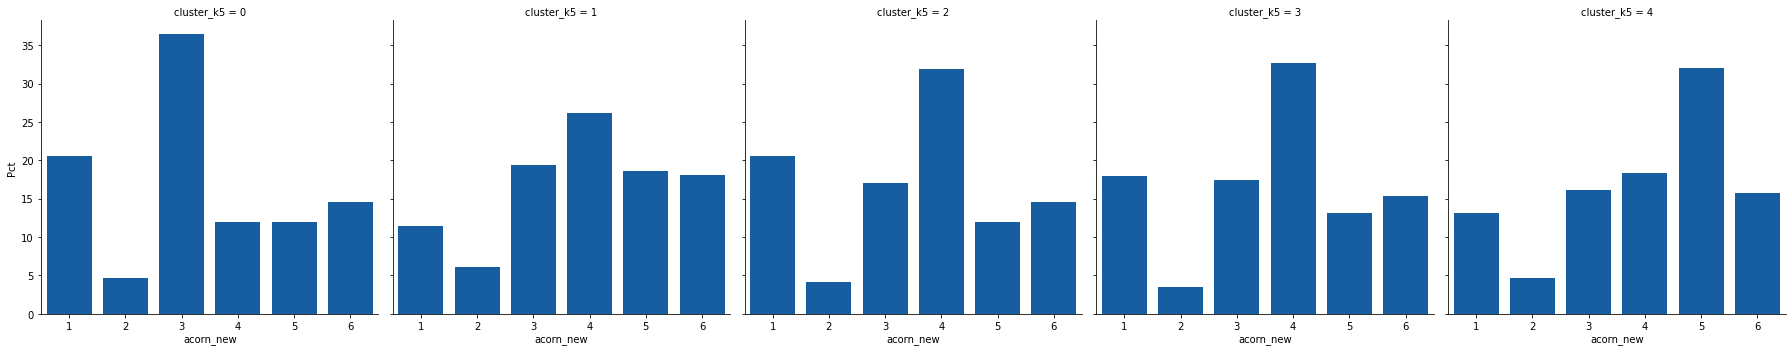

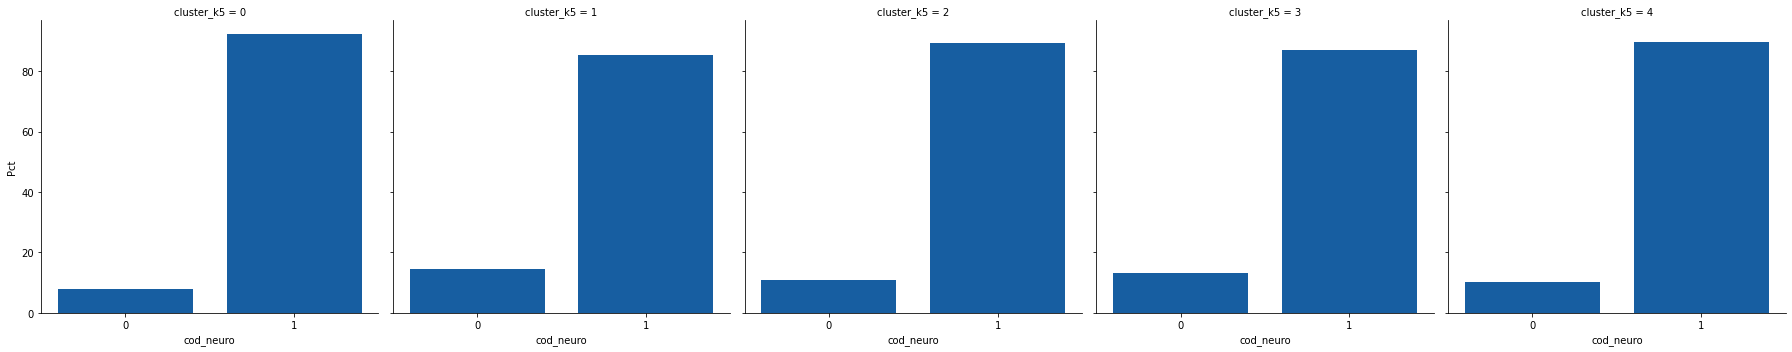

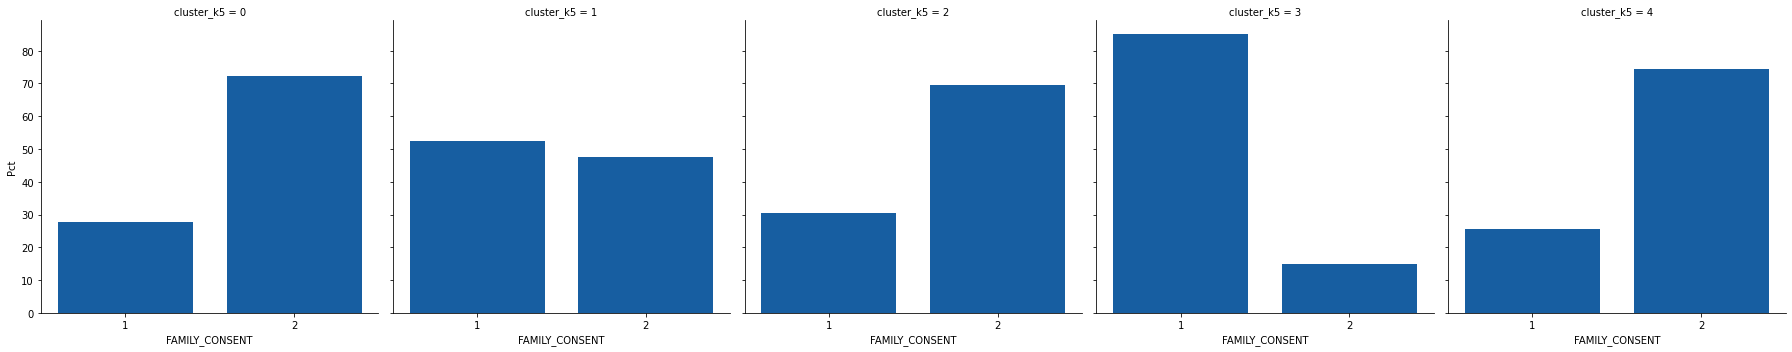

In [24]:
for cat in dcd_cats:
    cat_summary(5,cat)